
# Testing Custom Mask R-CNN Model

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

#import custom

# Root directory of the project
ROOT_DIR = "D:\MaskRCNN-aar"

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


WEIGHTS_PATH = "D:/MaskRCNN-aar/logs/object20210117T2236/mask_rcnn_object_0008.h5"   # change it


Using TensorFlow backend.


In [11]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 3  # Background + phone,laptop and mobile

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [12]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "/dataset/")
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [13]:
# Code for Customdataset class. Same code is present in custom.py file also
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        self.add_class("object", 1, "laptop")
        self.add_class("object", 2, "tab")
        self.add_class("object", 3, "phone")

        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations1 = json.load(open('D:/MaskRCNN-aar/Dataset/train/demo_json.json'))

        annotations = list(annotations1.values())  # don't need the dict keys

        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
           
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"laptop": 1,"tab": 2,"phone": 3}
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object", 
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
       
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):

        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [21]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
ROOT_DIR = "D:\MaskRCNN-aar\dataset"

def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = "D:/MaskRCNN-aar/dataset"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['laptop', 'tab', 'phone']
numids [1, 2, 3]
objects: ['laptop', 'tab', 'phone']
numids [1, 2, 3]
Images: 2
Classes: ['BG', 'laptop', 'tab', 'phone']


In [22]:
config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [23]:
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  D:/MaskRCNN-aar/logs/object20210117T2236/mask_rcnn_object_0008.h5
Re-starting from epoch 8


In [24]:
#Now, we are ready for testing our model on any image.

#RUN DETECTION
image_id = random.choice(dataset.image_ids)
#image_id = 'D:/MaskRCNN-aar/Dataset/val/1.jfif'
print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)



image id is : 0
image ID: object.1.jfif (0) D:/MaskRCNN-aar/dataset\val\1.jfif
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


gt_class_id              shape: (3,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:   17.00000  max: 1018.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  uint8
1
Processing 1 images
image                    shape: (183, 276, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


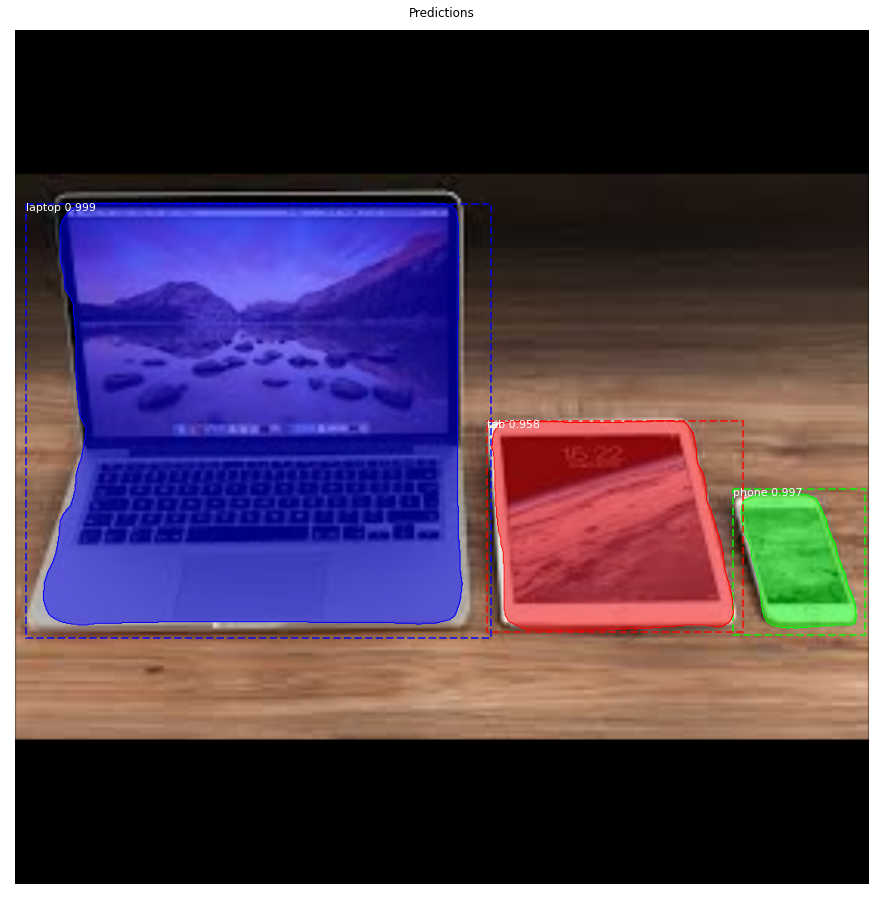

In [27]:
# Display results
x = get_ax(1)
r = results[0]
ax = plt.gca()
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=ax, title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
# This is for predicting images which are not present in dataset
path_to_new_image = 'D:/MaskRCNN-aar/test_img.jfif'
image1 = mpimg.imread(path_to_new_image)

# Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)

# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

1
Processing 1 images
image                    shape: (180, 279, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


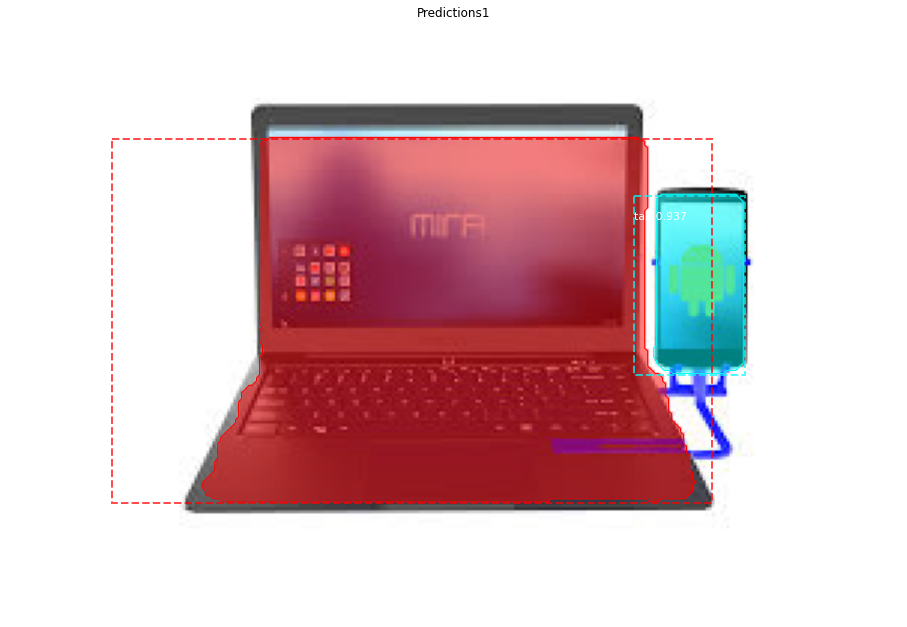

In [29]:
path_to_new_image = 'D:/MaskRCNN-aar/test_img_1.jfif'
image1 = mpimg.imread(path_to_new_image)

# Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)


# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")